In [1]:
### INSTRUCTIONS TO RUN
###
### To run this file you need to have the packages imported below installed in your 
### environment: pandas, seaborn, matplotlib, numpy, tensorflow, keras, gensim,
### sentence_transformers, scikit-learn, and scipy
###
### Additionally, you need the following data files generated by running data.ipynb
### with the appropriate raw input files (see that notebook for information on the 
### raw data). Here, you need:
###
### AIO_onTarget_V2_Featurized.csv
### AIO_offTarget_V2_Featurized.csv
###
###
### by Ian Hay, Jaeson Pyeon, and Zain Alam
### April 19, 2023 for CS4120 NLP Final Project

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, sem
sns.set()

2025-11-14 22:35:20.538200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-14 22:35:21.039367: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-11-14 22:35:21.039431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-11-14 22:35:21.039436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
# Standardized metrics function to use on each model
def get_metrics(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spr = spearmanr(y_true, y_pred)
    return {
        'mse' : mse,
        'r2' : r2,
        'spearman': spearmanr(y_true, y_pred)[0]
    }

In [4]:
def cross_validate_regression(model, x, y, n_splits=10):
    # computes the spearman correlation coefficient, r-squared, and mean squared error as a dictionary
    # for each cross validated data set.
    # takes in a model (estimator object), x data features and the y-label to predict, as well
    # as the number of splits (default is 10)
    #
    # returns a dictionary of metrics with each's length equal to the input n_splits
    
    kfold = KFold(n_splits=n_splits)
    
    # metric dict
    _metrics = {'mse': [],
                'r2': [],
                'spearman': []}
    
    for train_idx, test_idx in kfold.split(x, y):
        # build new network
        _model = clone(model)

        # get training data
        x_train = x[train_idx]
        y_true_train = y[train_idx]

        # get testing data
        x_test = x[test_idx]
        y_true_test = y[test_idx]

        # initialize an empty array same size as y_true
        y_pred = np.empty_like(y)

        # train on training data
        _model.fit(x_train, y_true_train)

        # predict testing data
        y_pred = _model.predict(x_test)
        
        # get regression metrics
        metrics_k = get_metrics(y_true_test, y_pred)

        _metrics['mse'].append(metrics_k['mse'])
        _metrics['r2'].append(metrics_k['r2'])
        _metrics['spearman'].append(metrics_k['spearman'])
    
    return _metrics

In [5]:
def cross_validate_regression_network(x, y, embSize, n_splits=10, numEpochs=5):
    # computes the spearman correlation coefficient, r-squared, and mean squared error as a dictionary
    # for each cross validated data set.
    # takes in x data features and the y-label to predict, as well
    # as the number of splits (default is 10), the embedding size, and the number of epochs
    # 
    # constructes a 3-hidden layer (embSizex128x128x128x1) dense feed forward neural network
    #
    # returns a dictionary of metrics with each's length equal to the input n_splits
    

    kfold = KFold(n_splits=n_splits)
    
    # metric dict
    _metrics = {'mse': [],
                'r2': [],
                'spearman': []}
    
    for train_idx, test_idx in kfold.split(x, y):
        # build new network
        backend.clear_session()

        _arch = [
        Flatten(input_shape=(embSize,)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
        ]

        model = Sequential(_arch)

        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

        # get training data
        x_train = x[train_idx]
        y_true_train = y[train_idx]

        # get testing data
        x_test = x[test_idx]
        y_true_test = y[test_idx]

        # initialize an empty array same size as y_true
        y_pred = np.empty_like(y)

        # train on training data
        model.fit(x_train, y_true_train, epochs=numEpochs, batch_size=32)

        # predict testing data
        y_pred = model.predict(x_test)
        
        # get regression metrics
        metrics_k = get_metrics(y_true_test, y_pred)

        _metrics['mse'].append(metrics_k['mse'])
        _metrics['r2'].append(metrics_k['r2'])
        _metrics['spearman'].append(metrics_k['spearman'])
    
    return _metrics

In [6]:
def w2vEmbedding(texts, embeddingSize=200) -> Word2Vec:
    # Train the Word2Vec model from Gensim. 
    # Below are the hyperparameters that are most relevant. 
    # But feel free to explore other 
    # options too:
    sg = 1 # skip-gram
    window = 5
    vector_size = embeddingSize
    min_count = 1

    model = Word2Vec(sg=sg, window=window, vector_size=vector_size, min_count=min_count)
    model.build_vocab(texts)
    return model

In [7]:
def transformerEmbedding(texts) -> SentenceTransformer:
    # use a pretrained BERT encoder to embed the target sequences
    bert = SentenceTransformer('distilbert-base-nli-mean-tokens')
    return bert.encode(texts, convert_to_numpy=True)

In [8]:
EMBEDDINGS_SIZE = 25
EMBEDDING_LENGTH_ON = EMBEDDINGS_SIZE * 20 # for the 20-mer sgRNA sequence
EMBEDDING_LENGTH_OFF = EMBEDDINGS_SIZE * 20 # for the 20-mer sgRNA sequence
TRANSFORMER_SIZE = 768

### Preprocessing & Embedding

,Spacer Sequence,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,G1,GA1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,GTAATGGCTTCCTCGTGAGT,0.789849,0,0,0,0,0,1,1,0,...,0,0,1,1,0,0,0,1,0,-24.633240
1,GCTCGTGCGAGTGATAGACC,0.552807,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,-26.546780
2,CACGGACGGTATATGGCAGG,0.149130,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-26.207115
3,TACTTCTGCGAGACACGGAC,0.767944,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,-25.848845
4,CGGCCCACGCTACTACAGTT,0.627909,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-27.072340


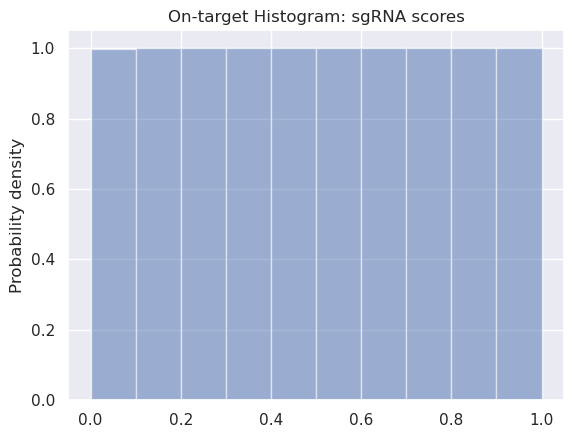

In [9]:
df = pd.read_csv("AIO_onTarget_V2_Featurized.csv", index_col=0)
plt.hist(df["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.ylabel('Probability density')
plt.title("On-target Histogram: sgRNA scores")
df.head()

In [10]:
df.shape

(24187, 1636)

,Spacer Sequence,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,G1,GA1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,TACCCTGGGACTGTACCCCC,0.604353,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,-26.433045
1,ACCCTTGCTGCACGACCTGC,0.730003,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,-28.734370
2,TCGCTCGCCCCGCTCTTCCT,0.229828,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,1,0,-29.864820
3,TGACGCCTCGGACGTGTCTG,0.232793,0,0,0,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,-28.405050
4,CGTCATAGCCAATCTTCTTC,0.399647,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,-23.162190


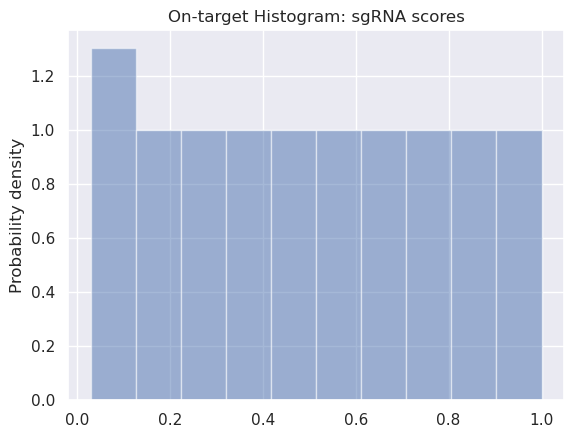

In [12]:
dfOff = pd.read_csv("AIO_offTarget_V2_Featurized.csv", index_col=0)
plt.hist(dfOff["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.ylabel('Probability density')
plt.title("On-target Histogram: sgRNA scores")
dfOff.head()

In [13]:
dfOff.shape

(64751, 1636)

In [14]:
TEST_SIZE = 0.1

indicesOn = np.arange(df.shape[0])
train_idx_on, test_idx_on = train_test_split(indicesOn, test_size=TEST_SIZE, train_size=None)

indicesOff = np.arange(dfOff.shape[0])
train_idx_off, test_idx_off = train_test_split(indicesOff, test_size=TEST_SIZE, train_size=None)

In [15]:
# train only on training indices
w2vmodel_sequence = w2vEmbedding(df["Spacer Sequence"].iloc[train_idx_on], EMBEDDINGS_SIZE)
print('Vocab size {}'.format(len(w2vmodel_sequence.wv)))
vocab_seq = len(w2vmodel_sequence.wv)
w2vmodel_sequence.wv.save_word2vec_format('sequence_embeddings.txt', binary=False)

Vocab size 4


In [16]:
embeddings = []
for _seq in df["Spacer Sequence"]:
    xEmb = []
    for _x in _seq:
        xEmb.extend(w2vmodel_sequence.wv[_x])
    embeddings.append(xEmb)

print(np.array(embeddings).shape)
df["Embedded Sequences"] = embeddings

(24187, 500)


In [17]:
trEmb = transformerEmbedding(df["Spacer Sequence"])

df["Transformer Sequences"] = list(trEmb)

dfEmb = df.copy(deep=True)[["Spacer Sequence", "sgRNA Normalized", "Embedded Sequences", "Transformer Sequences"]]
dfEmb.head()

,Spacer Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,GTAATGGCTTCCTCGTGAGT,0.789849,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...","[-0.88019717, 0.32914272, 1.1517112, -0.412180..."
1,GCTCGTGCGAGTGATAGACC,0.552807,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...","[-0.50036335, 0.20317282, 1.2306081, -0.480181..."
2,CACGGACGGTATATGGCAGG,0.149130,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.77627707, 0.42678365, 0.7114664, -0.484382..."
3,TACTTCTGCGAGACACGGAC,0.767944,"[0.0022871399, 0.029767632, -0.003253131, -0.0...","[-0.63332623, 0.40072587, 0.89975065, -0.53724..."
4,CGGCCCACGCTACTACAGTT,0.627909,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.8275509, 0.21623029, 1.0080035, -0.1860268..."


In [18]:
dfEmb.to_csv("embedded sequence data.csv")

In [19]:
data = pd.read_csv("embedded sequence data.csv")
dfEmb = data.drop(data.columns[0], axis=1) # drop unnamed column
dfEmb.head()

,Spacer Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,GTAATGGCTTCCTCGTGAGT,0.789849,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...",[-8.80197167e-01 3.29142720e-01 1.15171123e+...
1,GCTCGTGCGAGTGATAGACC,0.552807,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...",[-5.00363350e-01 2.03172818e-01 1.23060811e+...
2,CACGGACGGTATATGGCAGG,0.149130,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-0.77627707 0.42678365 0.7114664 -0.484382...
3,TACTTCTGCGAGACACGGAC,0.767944,"[0.0022871399, 0.029767632, -0.003253131, -0.0...",[-0.63332623 0.40072587 0.89975065 -0.537243...
4,CGGCCCACGCTACTACAGTT,0.627909,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-8.27550888e-01 2.16230288e-01 1.00800347e+...


In [20]:
# train word2vec only on the training indices
w2vmodel_sequence = w2vEmbedding(dfOff["Spacer Sequence"].iloc[train_idx_off], EMBEDDINGS_SIZE)

print('Vocab size {}'.format(len(w2vmodel_sequence.wv)))
vocab_seq = len(w2vmodel_sequence.wv)
w2vmodel_sequence.wv.save_word2vec_format('sequence_embeddings.txt', binary=False)

embeddings = []
for _seq in dfOff["Spacer Sequence"]:
    xEmb = []
    for _x in _seq:
        xEmb.extend(w2vmodel_sequence.wv[_x]) # encode the embeddings into a concatenated array
    embeddings.append(xEmb)

print(np.array(embeddings).shape)
dfOff["Embedded Sequences"] = embeddings

trEmb = transformerEmbedding(dfOff["Spacer Sequence"])

dfOff["Transformer Sequences"] = list(trEmb)

dfEmbOff = dfOff.copy(deep=True)[["Spacer Sequence", "sgRNA Normalized", "Embedded Sequences", "Transformer Sequences"]]
dfEmbOff.head()

Vocab size 4
(64751, 500)


,Spacer Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,TACCCTGGGACTGTACCCCC,0.604353,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.684498, 0.32545617, 1.1369965, -0.23281805..."
1,ACCCTTGCTGCACGACCTGC,0.730003,"[-0.03263167, 0.017983193, -0.016548304, 0.003...","[-0.5825761, 0.11436698, 1.2382475, -0.3425785..."
2,TCGCTCGCCCCGCTCTTCCT,0.229828,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.4798674, 0.0142033305, 1.3465704, -0.02461..."
3,TGACGCCTCGGACGTGTCTG,0.232793,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.66681254, 0.12491148, 0.8853253, -0.299219..."
4,CGTCATAGCCAATCTTCTTC,0.399647,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...","[-0.7485278, 0.3552239, 0.90285397, -0.2164549..."


In [21]:
dfEmbOff.to_csv("off-target embedded sequence data.csv")

In [22]:
data = pd.read_csv("off-target embedded sequence data.csv")
dfEmbOff = data.drop(data.columns[0], axis=1) # drop unnamed column
dfEmbOff.head()

,Spacer Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,TACCCTGGGACTGTACCCCC,0.604353,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-6.84498012e-01 3.25456172e-01 1.13699651e+...
1,ACCCTTGCTGCACGACCTGC,0.730003,"[-0.03263167, 0.017983193, -0.016548304, 0.003...",[-5.82576096e-01 1.14366978e-01 1.23824751e+...
2,TCGCTCGCCCCGCTCTTCCT,0.229828,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-4.79867399e-01 1.42033305e-02 1.34657037e+...
3,TGACGCCTCGGACGTGTCTG,0.232793,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-6.66812539e-01 1.24911480e-01 8.85325313e-...
4,CGTCATAGCCAATCTTCTTC,0.399647,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...",[-0.7485278 0.3552239 0.90285397 -0.216454...


### On-target Modeling

In [23]:
xRawOn = df.drop(["sgRNA Normalized", "Spacer Sequence", "Embedded Sequences", "Transformer Sequences"], axis=1).values
xEmbOn = np.array([np.fromstring(_x[1:-1], sep=', ') for _x in dfEmb["Embedded Sequences"].values])
xTrOn = np.array([np.fromstring(_x[1:-1].replace("\n",""), sep=' ') for _x in dfEmb["Transformer Sequences"].values])
yOn = dfEmb["sgRNA Normalized"].values

In [24]:
xRawTrain = xRawOn[train_idx_on]
xRawTest = xRawOn[test_idx_on]
xEmbTrain = xEmbOn[train_idx_on]
xEmbTest = xEmbOn[test_idx_on]
xTrTrain = xTrOn[train_idx_on]
xTrTest = xTrOn[test_idx_on]

yTrain = yOn[train_idx_on]
yTest = yOn[test_idx_on]

In [25]:
# training bayesian ridge on the manually extracted features
model = BayesianRidge()
model.fit(xRawTrain, yTrain)
yPredBrOn = model.predict(xRawTest)

In [26]:
# training GBRT on the manually extracted features
model = GradientBoostingRegressor(n_estimators=1500, max_depth=2, min_samples_split=5)
model.fit(xRawTrain, yTrain)
yPredGbrtOn = model.predict(xRawTest)

In [27]:
# training feed forward network on Word2Vec embeddings
_arch = [
Flatten(input_shape=(EMBEDDING_LENGTH_ON,)),
Dense(128, activation='relu'),
Dense(128, activation='relu'),
Dense(128, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
yPredEmb = np.empty_like(yTest)

# train on training data
model.fit(xEmbTrain, yTrain, epochs=100, batch_size=256)

# predict testing data
yPredEmbOn = model.predict(xEmbTest)

Epoch 1/100
86/86 [==============================] - 1s 1ms/step - loss: 0.0985
Epoch 2/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0785
Epoch 3/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0780
Epoch 4/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0772
Epoch 5/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0759
Epoch 6/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0740
Epoch 7/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0722
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0706
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0693
Epoch 10/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0679
Epoch 11/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0665
Epoch 12/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0642
Epoch 13/100
86/86 [=================

In [28]:
# training feed forward network on pretrained BERT embeddings
_arch = [
Flatten(input_shape=(TRANSFORMER_SIZE,)),
Dense(128, activation='relu'),
Dense(128, activation='relu'),
Dense(128, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
y_pred = np.empty_like(yTest)

# train on training data
model.fit(xTrTrain, yTrain, epochs=100, batch_size=256)

# predict testing data
yPredTrOn = model.predict(xTrTest)

Epoch 1/100
86/86 [==============================] - 1s 2ms/step - loss: 0.0981
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0833
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0837
Epoch 4/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0825
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0827
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0829
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0818
Epoch 8/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 9/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0817
Epoch 10/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0811
Epoch 11/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0809
Epoch 12/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0805
Epoch 13/100
86/86 [=================

/tmp/ipykernel_17683/2232663307.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


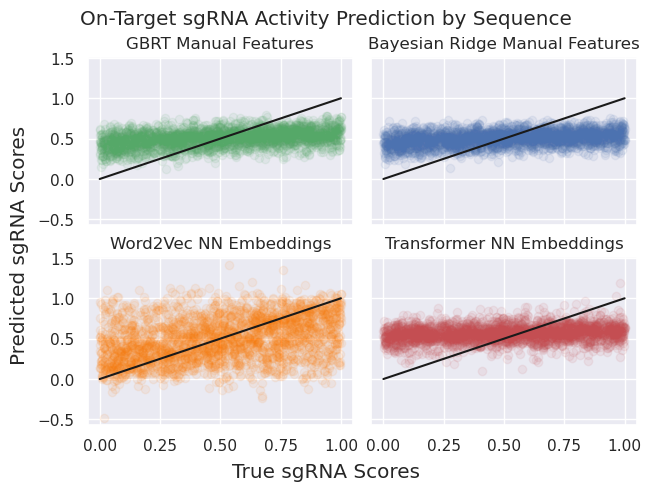

In [29]:
# plot the predicted values versus the true values for each model
# on the testing data

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, layout="constrained", sharex=True, sharey=True)

ax1 = plt.subplot(2,2,1)
ax1.scatter(yTest, yPredGbrtOn, c='g', alpha=0.08, label="Manual Features - GBRT")
ax1.plot([0, 1], [0, 1], 'k-', label="True Values")
ax1.set_title("GBRT Manual Features")


ax2 = plt.subplot(2,2,2)
ax2.scatter(yTest, yPredBrOn, c='b', alpha=0.08, label="Manual Features - Bayesian Ridge")
ax2.plot([0, 1], [0, 1], 'k-', label="True Values")
ax2.set_title("Bayesian Ridge Manual Features")

ax3 = plt.subplot(2,2,3)
ax3.scatter(yTest, yPredEmbOn, c='tab:orange', alpha=0.08, label="Word2Vec Embeddings")
ax3.plot([0, 1], [0, 1], 'k-', label="True Values")
ax3.set_title("Word2Vec NN Embeddings")

ax4 = plt.subplot(2,2,4)
ax4.scatter(yTest, yPredTrOn, c='r', alpha=0.08, label="Transformer Embeddings")
ax4.plot([0, 1], [0, 1], 'k-', label="True Values")
ax4.set_title("Transformer NN Embeddings")

# plt.legend()
# plt.axis("equal")
fig.supylabel("Predicted sgRNA Scores")
fig.supxlabel("True sgRNA Scores")
fig.suptitle("On-Target sgRNA Activity Prediction by Sequence")
fig.savefig("on-target sgrna activity prediction.png")
fig.show()

In [30]:
# cross-validate each of the models to obtain metrics
model = BayesianRidge()
br_metrics = cross_validate_regression(model, xRawOn, yOn)

model = GradientBoostingRegressor(n_estimators=1500, max_depth=2, min_samples_split=5)
gbrt_metrics = cross_validate_regression(model, xRawOn, yOn)

w2vnn_metrics = cross_validate_regression_network(xEmbOn, yOn, embSize=EMBEDDING_LENGTH_ON, numEpochs=100)

tfnn_metrics = cross_validate_regression_network(xTrOn, yOn, embSize=TRANSFORMER_SIZE, numEpochs=100)

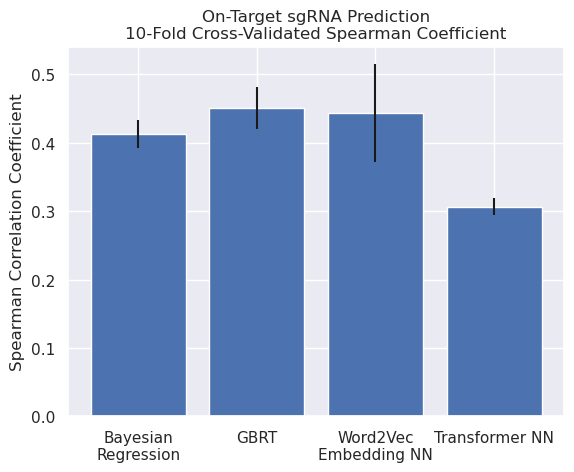

In [ ]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Spearman Correlation Coefficient")
plt.title("On-Target sgRNA Prediction\n10-Fold Cross-Validated Spearman Coefficient")
plt.savefig("on-target sgrna spearman barchart.png")

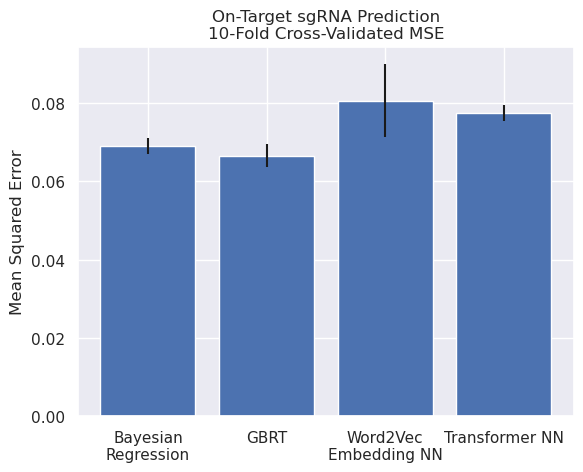

In [ ]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['mse']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['mse']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Mean Squared Error")
plt.title("On-Target sgRNA Prediction\n10-Fold Cross-Validated MSE")
plt.savefig("on-target sgrna mse barchart.png")

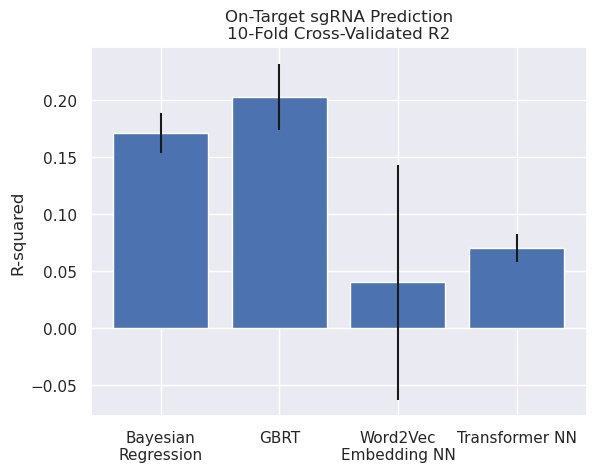

In [ ]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['r2']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['r2']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("R-squared")
plt.title("On-Target sgRNA Prediction\n10-Fold Cross-Validated R2")
plt.savefig("on-target sgrna r2 barchart.png")

### Off-target Modeling

In [ ]:
xRaw = dfOff.drop(["sgRNA Normalized", "Spacer Sequence", "Embedded Sequences", "Transformer Sequences"], axis=1).values
xEmb = np.array([np.fromstring(_x[1:-1], sep=', ') for _x in dfEmbOff["Embedded Sequences"].values])
xTr = np.array([np.fromstring(_x[1:-1].replace("\n",""), sep=' ') for _x in dfEmbOff["Transformer Sequences"].values])
y = dfOff["sgRNA Normalized"].values

In [ ]:
xRawTrain = xRaw[train_idx_off]
xRawTest = xRaw[test_idx_off]
xEmbTrain = xEmb[train_idx_off]
xEmbTest = xEmb[test_idx_off]
xTrTrain = xTr[train_idx_off]
xTrTest = xTr[test_idx_off]

yTrain = y[train_idx_off]
yTest = y[test_idx_off]

In [ ]:
# training bayesian ridge on the manually extracted features
model = BayesianRidge()
model.fit(xRawTrain, yTrain)
yPredBr = model.predict(xRawTest)

In [ ]:
# training GBRT on the manually extracted features
model = GradientBoostingRegressor(n_estimators=1500, max_depth=2, min_samples_split=5)
model.fit(xRawTrain, yTrain)

yPredGbrt = model.predict(xRawTest)

In [ ]:
# training feed forward network on Word2Vec embeddings
_arch = [
Flatten(input_shape=(EMBEDDING_LENGTH_OFF,)),
Dense(128, activation='relu'),
Dense(128, activation='relu'),
Dense(128, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
yPredEmb = np.empty_like(yTest)

# train on training data
model.fit(xEmbTrain, yTrain, epochs=100, batch_size=256)

# predict testing data
yPredEmb = model.predict(xEmbTest)

Epoch 1/50
1822/1822 [==============================] - 2s 781us/step - loss: 0.0540
Epoch 2/50
1822/1822 [==============================] - 2s 952us/step - loss: 0.0327
Epoch 3/50
1822/1822 [==============================] - 2s 943us/step - loss: 0.0263
Epoch 4/50
1822/1822 [==============================] - 2s 950us/step - loss: 0.0238
Epoch 5/50
1822/1822 [==============================] - 2s 923us/step - loss: 0.0220
Epoch 6/50
1822/1822 [==============================] - 2s 959us/step - loss: 0.0209
Epoch 7/50
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0198
Epoch 8/50
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0191
Epoch 9/50
1822/1822 [==============================] - 2s 975us/step - loss: 0.0185
Epoch 10/50
1822/1822 [==============================] - 2s 947us/step - loss: 0.0179
Epoch 11/50
1822/1822 [==============================] - 2s 956us/step - loss: 0.0175
Epoch 12/50
1822/1822 [==============================] - 1s 788us/s

In [ ]:
# training feed forward network on pretrained BERT embeddings
_arch = [
Flatten(input_shape=(TRANSFORMER_SIZE,)),
Dense(128, activation='relu'),
Dense(128, activation='relu'),
Dense(128, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
y_pred = np.empty_like(yTest)

# train on training data
model.fit(xTrTrain, yTrain, epochs=100, batch_size=256)

# predict testing data
yPredTr = model.predict(xTrTest)

Epoch 1/50
1822/1822 [==============================] - 2s 927us/step - loss: 0.0475
Epoch 2/50
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0374
Epoch 3/50
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0350
Epoch 4/50
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0334
Epoch 5/50
1822/1822 [==============================] - 2s 962us/step - loss: 0.0323
Epoch 6/50
1822/1822 [==============================] - 2s 981us/step - loss: 0.0317
Epoch 7/50
1822/1822 [==============================] - 2s 863us/step - loss: 0.0307
Epoch 8/50
1822/1822 [==============================] - 2s 923us/step - loss: 0.0304
Epoch 9/50
1822/1822 [==============================] - 2s 961us/step - loss: 0.0299
Epoch 10/50
1822/1822 [==============================] - 2s 982us/step - loss: 0.0295
Epoch 11/50
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0291
Epoch 12/50
1822/1822 [==============================] - 2s 1ms/step - 

/tmp/ipykernel_54398/3547032916.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


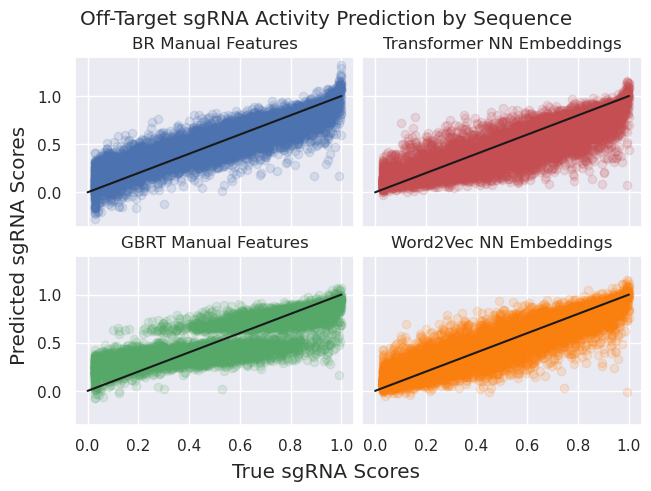

In [ ]:
# plot the predicted values versus the true values for each model
# on the testing data

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, layout="constrained", sharex=True, sharey=True)

ax1 = plt.subplot(2,2,1)
ax1.scatter(yTest, yPredBr, c='b', alpha=0.15, label="Manual Features - Bayesian Ridge")
ax1.plot([0, 1], [0, 1], 'k-', label="True Values")
ax1.set_title("BR Manual Features")

ax2 = plt.subplot(2,2,2)
ax2.scatter(yTest, yPredTr, c='r', alpha=0.15, label="Transformer Embeddings")
ax2.plot([0, 1], [0, 1], 'k-', label="True Values")
ax2.set_title("Transformer NN Embeddings")

ax3 = plt.subplot(2,2,3)
ax3.scatter(yTest, yPredGbrt, c='g', alpha=0.15, label="Manual Features - GBRT")
ax3.plot([0, 1], [0, 1], 'k-', label="True Values")
ax3.set_title("GBRT Manual Features")

ax4 = plt.subplot(2,2,4)
ax4.scatter(yTest, yPredEmb, c='tab:orange', alpha=0.15, label="Word2Vec Embeddings")
ax4.plot([0, 1], [0, 1], 'k-', label="True Values")
ax4.set_title("Word2Vec NN Embeddings")

fig.supylabel("Predicted sgRNA Scores")
fig.supxlabel("True sgRNA Scores")
fig.suptitle("Off-Target sgRNA Activity Prediction by Sequence")
fig.savefig("off-target sgrna activity prediction.png")
fig.show()

In [ ]:
# cross-validate each of the models to obtain metrics

model = BayesianRidge()
br_metrics = cross_validate_regression(model, xRaw, y)

model = GradientBoostingRegressor(n_estimators=1500, max_depth=2, min_samples_split=5)
gbrt_metrics = cross_validate_regression(model, xRaw, y)

w2vnn_metrics = cross_validate_regression_network(xEmb, y, embSize=EMBEDDING_LENGTH_OFF, numEpochs=100)

tfnn_metrics = cross_validate_regression_network(xTr, y, embSize=TRANSFORMER_SIZE, numEpochs=100)

Epoch 1/50
1822/1822 [==============================] - 2s 758us/step - loss: 0.0519
Epoch 2/50
1822/1822 [==============================] - 1s 702us/step - loss: 0.0307
Epoch 3/50
1822/1822 [==============================] - 1s 699us/step - loss: 0.0248
Epoch 4/50
1822/1822 [==============================] - 1s 751us/step - loss: 0.0220
Epoch 5/50
1822/1822 [==============================] - 2s 854us/step - loss: 0.0203
Epoch 6/50
1822/1822 [==============================] - 2s 976us/step - loss: 0.0193
Epoch 7/50
1822/1822 [==============================] - 2s 876us/step - loss: 0.0185
Epoch 8/50
1822/1822 [==============================] - 2s 936us/step - loss: 0.0178
Epoch 9/50
1822/1822 [==============================] - 2s 933us/step - loss: 0.0172
Epoch 10/50
1822/1822 [==============================] - 2s 922us/step - loss: 0.0167
Epoch 11/50
1822/1822 [==============================] - 1s 680us/step - loss: 0.0163
Epoch 12/50
1822/1822 [==============================] - 1s 679

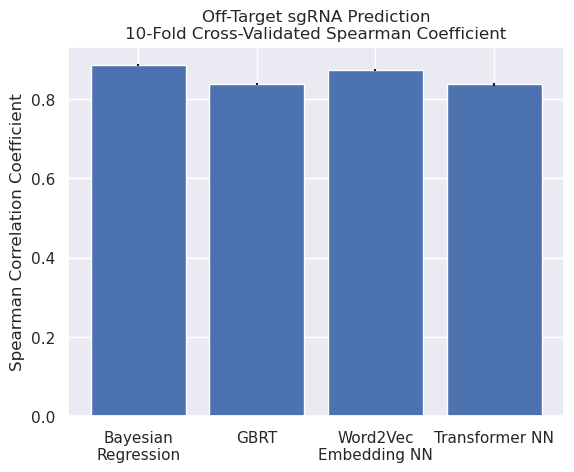

In [ ]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Spearman Correlation Coefficient")
plt.title("Off-Target sgRNA Prediction\n10-Fold Cross-Validated Spearman Coefficient")
plt.savefig("off-target sgrna spearman barchart.png")

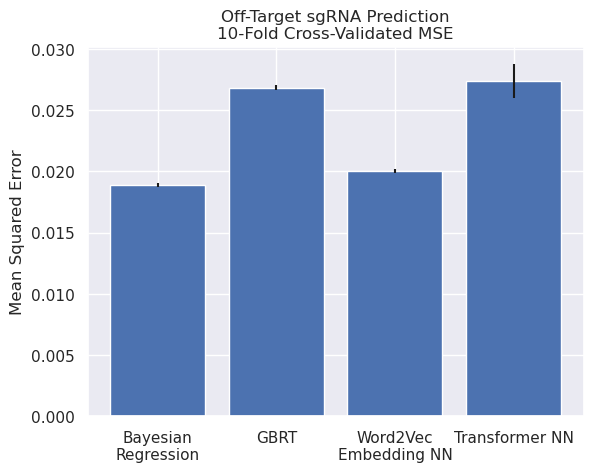

In [ ]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['mse']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['mse']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Mean Squared Error")
plt.title("Off-Target sgRNA Prediction\n10-Fold Cross-Validated MSE")
plt.savefig("off-target sgrna mse barchart.png")

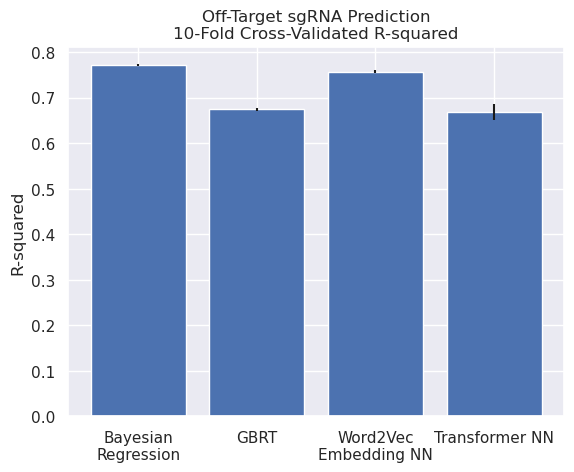

In [ ]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['r2']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['r2']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("R-squared")
plt.title("Off-Target sgRNA Prediction\n10-Fold Cross-Validated R-squared")
plt.savefig("off-target sgrna r2 barchart.png")